In [61]:
# simple_covnet.py

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class LeNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter1_num':6,  'filter1_size':4, 'filter2_num':16, 'filter2_size':4, 'pad':0, 'stride':1 },
                hidden_size2 = 120, hidden_size3 = 84, output_size=10, weight_init_std=0.01):
        filter1_num = conv_param['filter1_num']
        filter1_size = conv_param['filter1_size']
        filter2_num = conv_param['filter2_num']
        filter2_size = conv_param['filter2_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']

        input_size = input_dim[1]
        conv_output_size1 = (input_size - filter1_size + 2*filter_pad) / filter_stride + 1
        pool_output_size1 = int(filter1_num * (conv_output_size1/2) * (conv_output_size1/2))

        conv_output_size2 = (input_size - filter2_size + 2*filter_pad) / filter_stride + 1
        pool_output_size2 = int(filter2_num * (conv_output_size2/2) * (conv_output_size2/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter1_num, input_dim[0], filter1_size, filter1_size)
        self.params['b1'] = np.zeros(filter1_num)

        self.params['W2'] = weight_init_std * \
                            np.random.randn(filter2_num, filter1_num, filter2_size, filter2_size)
        self.params['b2'] = np.zeros(filter2_num)

        self.params['W3'] = weight_init_std * \
                            np.random.randn(filter2_num * filter2_size * filter2_size, hidden_size2)
        self.params['b3'] = np.zeros(hidden_size2)

        self.params['W4'] = weight_init_std * \
                            np.random.randn(hidden_size2, hidden_size3)
        self.params['b4'] = np.zeros(hidden_size3)

        self.params['W5'] = weight_init_std * \
                            np.random.randn(hidden_size3, output_size)
        self.params['b5'] = np.zeros(output_size)



        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)

        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu2'] = Relu()
        self.layers['Pool2'] = Pooling(pool_h=2, pool_w=2, stride=2)

        self.layers['Affine1'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = Relu()

        self.layers['Affine2'] = Affine(self.params['W4'], self.params['b4'])
        self.layers['Relu4'] = Relu()

        self.layers['Affine3'] = Affine(self.params['W5'], self.params['b5'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3, 4, 5):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W3'], grads['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W4'], grads['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W5'], grads['b5'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Conv2', 'Affine1', 'Affine2', 'Affine3']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


3531845
train loss:0.7344349241151766
train loss:0.9585020587106549
train loss:0.8985033417562711
train loss:0.8540717679798946
train loss:0.6965780524061307
train loss:0.7579856050953269
train loss:0.8096656773411531
train loss:0.6634982055022088
train loss:0.7687603572550833
train loss:0.8412956978644113
train loss:0.8516737619599303
train loss:0.6553954652645806
train loss:0.8374784610818113
train loss:0.742386534021888
train loss:0.7355015463340667
train loss:0.7821031778094786
train loss:0.5869875662045294
train loss:0.8596466755750126
train loss:0.7456404699294731
train loss:0.8397896430274018
train loss:0.7589684656672963
train loss:0.8257663817124508
train loss:0.6915632583240581
train loss:0.8565307559028368
train loss:0.7318487691986298
train loss:0.770833419985882
train loss:0.7417612549470998
train loss:0.7200185331417154
train loss:0.7388536778106407
train loss:0.6966146719917761
train loss:0.660374466139811
train loss:0.6963827620977786
train loss:0.791993078807617
train 

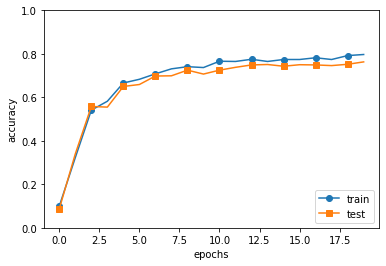

In [62]:
# train_convnet.py

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = LeNet(input_dim=(1,28,28))
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


(16, 6, 4, 4)


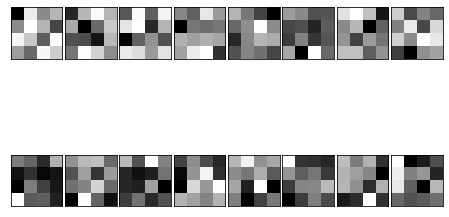

(16, 6, 4, 4)


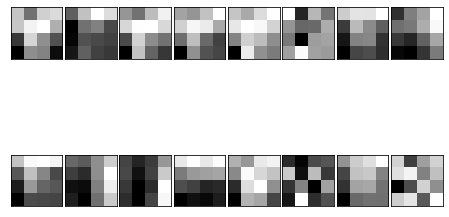

In [65]:
# visualize_filter.py

# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    print(filters.shape)
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = LeNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W2'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W2'])


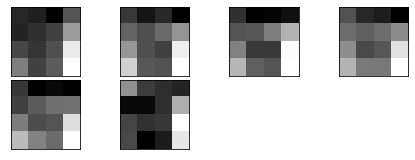

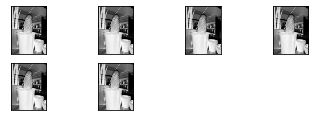

In [66]:
# apply_filter.py

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')


network = LeNet(input_dim=(1,28,28))

# 학습된 가중치
network.load_params("params.pkl")

filter_show(network.params['W1'], 16, show_num=6)

img = imread('../dataset/cactus_gray.png')
img = img.reshape(1, 1, *img.shape)

fig = plt.figure()

w_idx = 1

for i in range(6):
    w = network.params['W1'][i]
    b = 0  # network.params['b1'][i]

    w = w.reshape(1, *w.shape)
    #b = b.reshape(1, *b.shape)
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
    out = out.reshape(out.shape[2], out.shape[3])
    
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()
